In [1]:
import sys
import os
import numpy as np
import torch
from torch import device, nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os import mkdir
import torch.optim as optim
import scipy
import matplotlib
import plotly.express as px
import pandas as pdfr
from sklearn.metrics import f1_score
import gc
import sklearn
import pandas as pd

Specify directory of folder 'IHDA'

In [2]:
dir_IHDA               = '/content/drive/MyDrive/Graduate/IHDA/'
dir_required_functions = dir_IHDA + 'RequiredFunctions/'

In [3]:
import sys
sys.path.append(dir_required_functions)
sys.path.append(dir_required_functions + 'VAE')
sys.path.append(dir_required_functions + 'FC')
sys.path.append(dir_required_functions+'Potential')
sys.path.append(dir_required_functions+'LoadProcessData')

If you run on google colab:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this notebook hyperparametersearch for different values of beta is performed for the VAE used to retrain the first layer of the baseline classifier. 
Beta represents the penalization weight on the Kullback-Leibler divergence of the cost function of the VAE. 

In [92]:
import VAE
import basic_functions
import load_process_data as lpd
import train_VAE
import losses
import eval_VAE
import FC
import eval_FC
import potential
import eval_potential
import retrain_FC

#**Load training, validation and testing data:**

Short definition of those three datasets: 

*   **Training Dataset:** The samples of dataset used to fit the model.
*  **Validation Dataset:** The samples of dataset used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters.
*   **Test Dataset:** The sample of dataset used to provide an unbiased evaluation of a final model fit on the training dataset.



In [6]:
dir_fc_base   = dir_IHDA + 'BaselineClassifier/Classifier/'     # Directory of baseline classifier 
dir_data_pp   = dir_fc_base + 'Data/'                           # Directory of splitted data used for training the baseline classifier

Load training, validation and testing data:

In [7]:
# Load training data:
x_train          = torch.load(dir_data_pp + 'x_train.pth')
y_train          = torch.load(dir_data_pp + 'y_train.pth')
x_train_upsample = torch.load(dir_data_pp + 'x_train_upsample.pth')
y_train_upsample = torch.load(dir_data_pp + 'y_train_upsample.pth')

# Load validation data:
x_validate          = torch.load(dir_data_pp + 'x_validate.pth')
y_validate          = torch.load(dir_data_pp + 'y_validate.pth')
x_validate_upsample = torch.load(dir_data_pp + 'x_validate_upsample.pth')
y_validate_upsample = torch.load(dir_data_pp + 'y_validate_upsample.pth')

# Load testing data: 
x_test             = torch.load(dir_data_pp + 'x_test.pth')
y_test             = torch.load(dir_data_pp + 'y_test.pth')

To train the VAE on a balanced dataset set the variable *upsample_state* equal to 1. In that case the VAE will be trained on a dataset in which each class is represented by an equal amount of samples. This is achieved by upsampling underrepresented classes.

In [8]:
upsample_state = 1
if upsample_state == 1:
  x_train = x_train_upsample
  y_train = y_train_upsample

  x_validate = x_validate_upsample
  y_validate = y_validate_upsample

#**Evaluate baseline classifier:**

In section some statitics about the baseline classifier are printed. The confusion matrix is interesting to consider, since the latent space of the VAE should represent similar difficulties of the classifier as the confusion matrix (overlap in the latent space equal to missclassification).

Define hyperparameters of classifier:

In [9]:
dir_fc_base_best   = dir_fc_base + 'best_model.pth' 
device             = 'cuda' # Device where calculations are performed

Initialize base classifier:

In [10]:
# Load and initialize trained VAE:
fc_base  = FC.FC(dropout_fc = 0).to(device)
fc_base  = basic_functions.initialize_model(fc_base,dir_fc_base_best)
fc_base.eval()

FC(
  (batch1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=753, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=8, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

Confusion matrix:

In [11]:
y_pred      = eval_FC.classifier_predict(fc_base, x_test, device)
conf_matrix = eval_FC.calc_confusion_matrix(y_pred,y_test)
conf_matrix.style.set_table_attributes("style='display:inline'").set_caption('Confusion Matrix')

,Still,Walking,Run,Bike,Car,Bus,Train,Subway
Still,10493,157,0,97,210,234,165,220
Walking,263,8197,14,79,1,28,2,143
Run,3,44,3976,32,1,0,0,1
Bike,104,499,125,5292,27,82,3,16
Car,607,7,1,45,9457,4677,214,313
Bus,416,166,1,167,1277,8162,243,346
Train,631,103,0,63,225,484,3669,2603
Subway,266,25,1,9,31,41,844,2773


#**Train VAE:**

**Load and initialize VAE:**

Specify hyperparameters of VAE:

In [12]:
latent_dims        = 8      # Latent dimension
device             = 'cuda' # Device where calculations are performed
dropout_ratio_1    = 0.25   # Dropout ratio

Initialize VAE_1:

In [13]:
VAE_1 = VAE.VariationalAutoencoder(latent_dims,dropout_ratio_1)
VAE_1 = VAE.initialize_VAE_1(VAE_1, dir_fc_base_best)

Specify training hyperparameters:

In [116]:
batch_size  = 500     # batch size
epochs      = 80      # number of epochs
layer       = 1       # layer to optimize
beta        = 0.025   # 0.005 beta of VAE # 0.02 # between 0.1 and 0.01
betas       = [     0.02, 
                    0.05,
                    0.075,
                     0.1,
                     0.5,
                       5,
                      10]
#betas       = [0.000001,
#                0.00001,
#                 0.0001,
#                  0.001,
#                    0.01,
#                    0.025,
#                     0.1,
#                       1]

lr          = 0.0001  # Learning rate of VAE 

train_VAE_1_state =   1      # 0 not train VAE, train_VAE_state := 1 train VAE
device            = 'cuda'  # device on which the training is performed

Create dataloaders:

In [117]:
trainloader      = lpd.generate_dataloader(x_train,y_train, batch_size, shuffle = True)
validationloader = lpd.generate_dataloader(x_validate, y_validate, batch_size, shuffle = True)
testloader       = lpd.generate_dataloader(x_test, y_test, batch_size, shuffle = True)

Start training procedure:

In [ ]:
def main(VAE_1,beta,latent_dims,epochs,layer,lr,trainloader,validationloader):
  # Create directory to store model:
  dir_store_folder          = train_VAE.create_directory_VAE(beta, latent_dims, epochs,layer,dir_IHDA)
  
  # Initialize optimizer:
  optimizer  = torch.optim.Adam(VAE_1.parameters(), lr = lr, betas=(0.9, 0.999))

  # Push model to device:
  VAE_1.to(device)

  # Start training procedure:
  history, VAE_1, optimizer = train_VAE.train_test(beta,VAE_1,dir_store_folder, optimizer,trainloader,validationloader,epochs,device)
  
  # Store final model:
  basic_functions.store_model(dir_store_folder, VAE_1,epochs, optimizer, model_name = 'final_model.pth')
  
  # Plot seperate losses:
  losses.plot_losses_seperatly(history) 
  print('Done with training')
  return history

if train_VAE_1_state == 1:
  # Iterate over betas:
  for beta in betas:
    # Initialize VAE_1:
    VAE_1 = VAE.VariationalAutoencoder(latent_dims,dropout_ratio_1)
    VAE_1 = VAE.initialize_VAE_1(VAE_1, dir_fc_base_best)
    
    # Initialize optimizer:
    optimizer = optim.Adam(VAE_1.parameters(), lr = lr, betas=(0.9, 0.999))   #lr = 0.0000001 (normalized works and ) lr =  0.0000003, betas=(0.9, 0.999)
    
    history   = main(VAE_1,beta,latent_dims,epochs,layer,lr,trainloader,validationloader)

Directory already exists

Best validation loss: 9194.191510139628

Saving best model for epoch: 1

Epoch [0], train_loss: 11875.8420,valid_loss: 9194.1915

Best validation loss: 8274.362751412898

Saving best model for epoch: 2

Epoch [1], train_loss: 8266.5202,valid_loss: 8274.3628

Best validation loss: 7933.850970329122

Saving best model for epoch: 3

Epoch [2], train_loss: 7676.2300,valid_loss: 7933.8510

Best validation loss: 7340.730847947141

Saving best model for epoch: 4

Epoch [3], train_loss: 7356.9172,valid_loss: 7340.7308

Best validation loss: 6855.932108128324

Saving best model for epoch: 5

Epoch [4], train_loss: 7123.5037,valid_loss: 6855.9321

Best validation loss: 6737.750851894947

Saving best model for epoch: 6

Epoch [5], train_loss: 6961.2034,valid_loss: 6737.7509

Best validation loss: 6640.938237616357

Saving best model for epoch: 7

Epoch [6], train_loss: 6837.8860,valid_loss: 6640.9382
Epoch [7], train_loss: 6736.4631,valid_loss: 6711.6884

Best validation

#**Evaluate hyperparameter search:**

In the following, the models trained during hyperparametersearch are evaluated and the most suitable value for 'beta' for optimizing the first layer of the baseline classifier will be determined.

It is started by sampling a random datasample from the testset and derive its reconstruction by applying it to the different trained VAEs. This allows to visually compare the reconstructions of different beta VAEs.



**Evaluate reconstructed signals:**
It is started by sampling a random datasample from the testset and derive its reconstruction by applying it to the different trained VAEs. This allows to visually compare the reconstructions of different beta VAEs.

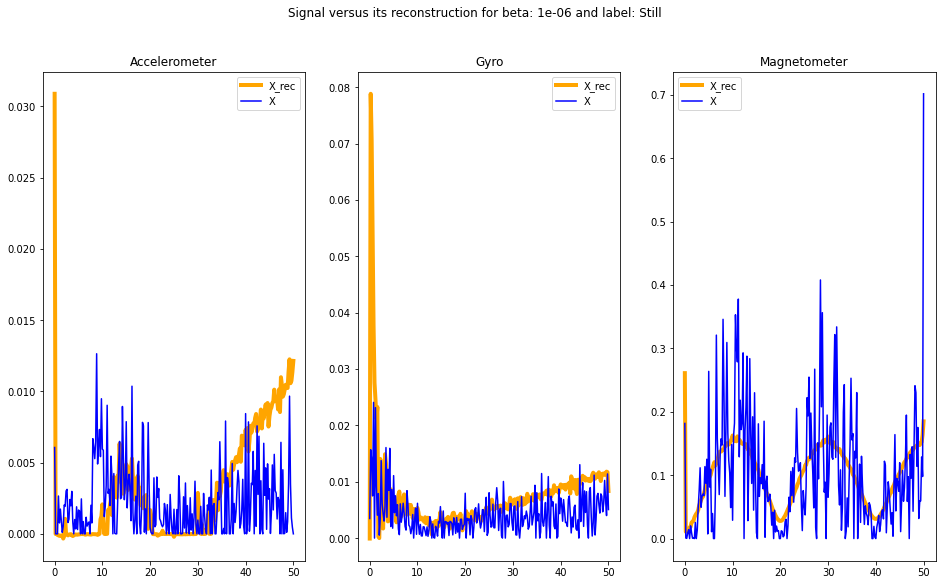

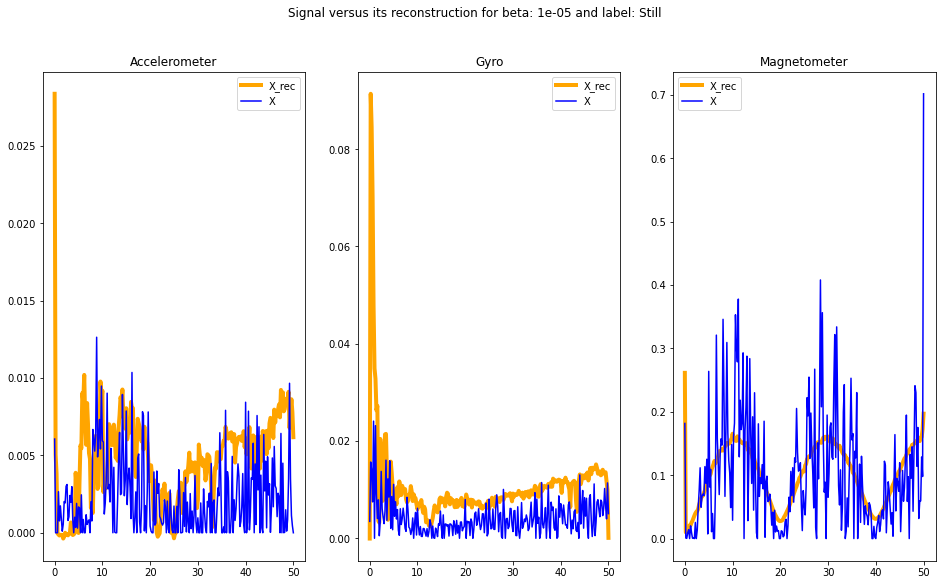

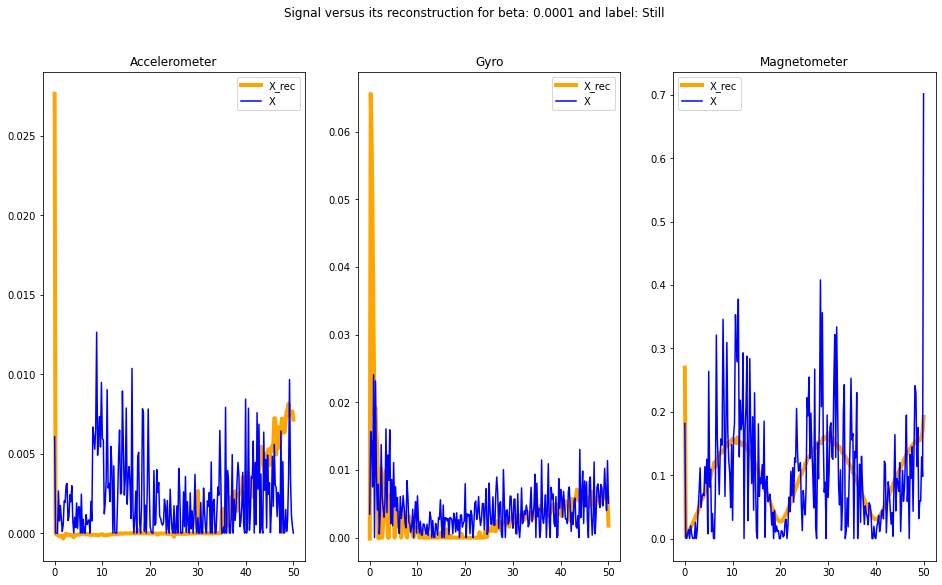

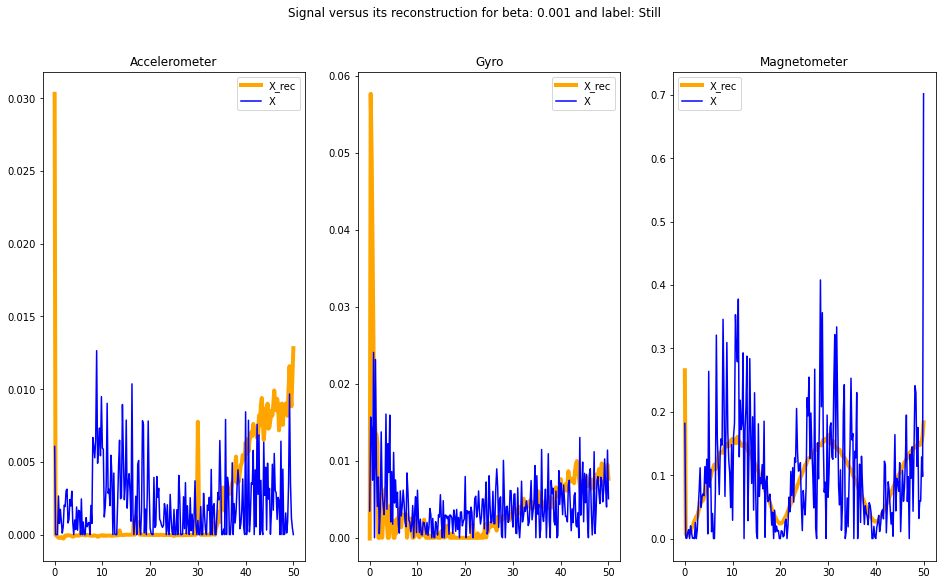

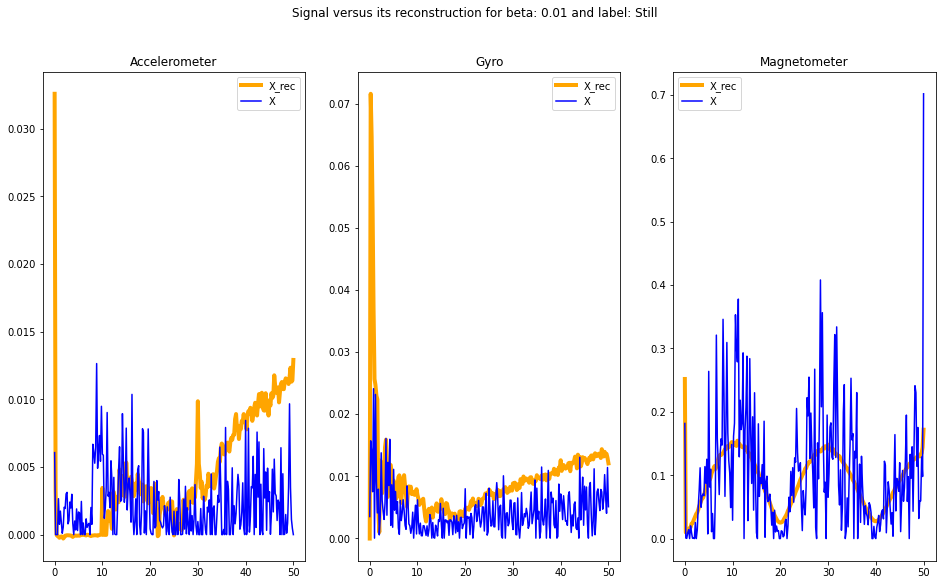

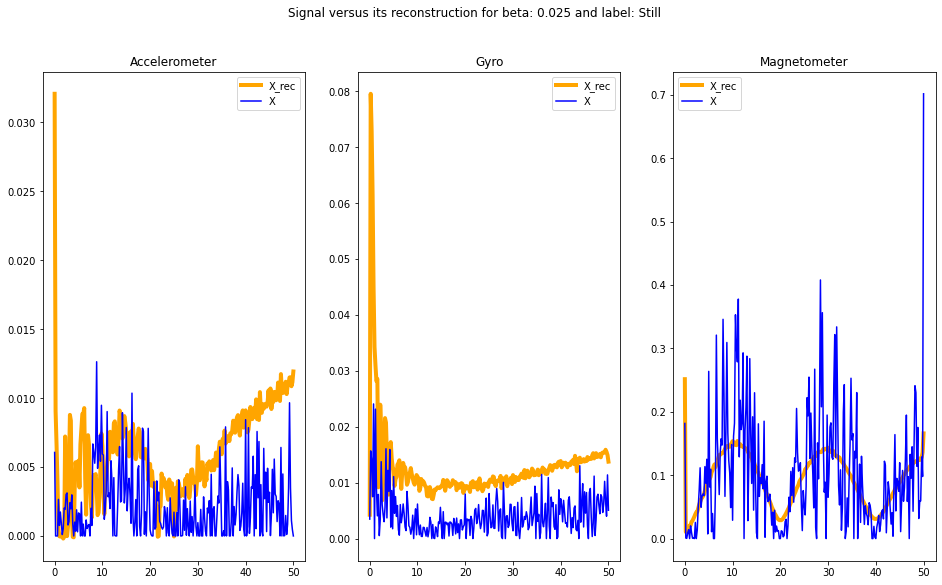

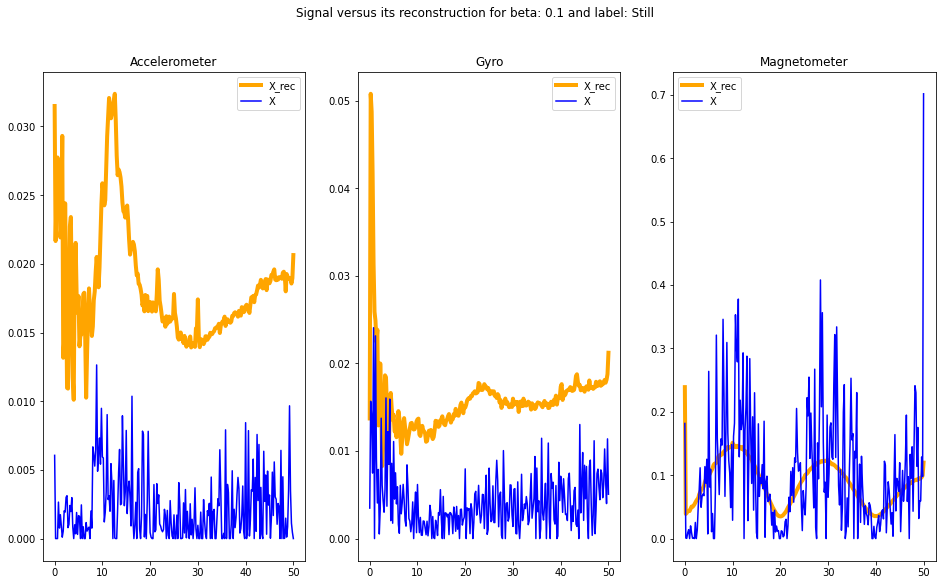

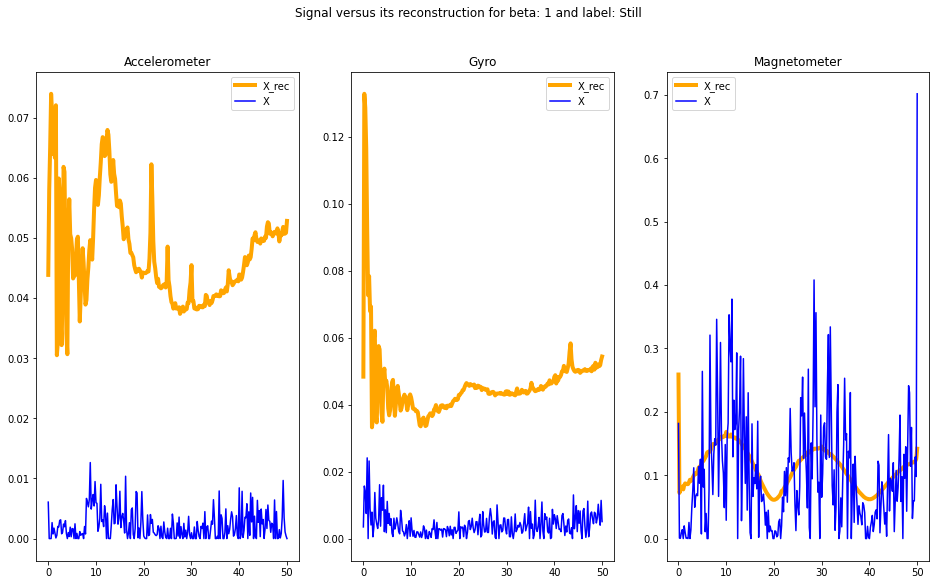

In [81]:
# Extract random datasample:
idx_sample = np.random.randint(0,len(x_test),1)
x_sample   = x_test[idx_sample].view(753)
y_sample   = y_test[idx_sample].detach().cpu().numpy()

# Iterate over betas:
for beta in betas:
  # Directory of beta VAE: 
  dir_VAE_1 = dir_IHDA + 'VAE/VAE_'+str(layer)+'/Models/VAE_beta_'+str(beta) + '_latent_dims_' + str(latent_dims) + '_epochs_' + str(epochs) +'/' + 'best_model.pth'
  
  # Load and initialize trained VAE:
  VAE_1  = VAE.VariationalAutoencoder(latent_dims,dropout_ratio_1).to(device)
  VAE_1  = basic_functions.initialize_model(VAE_1,dir_VAE_1)
  VAE_1.eval()
  
  # Derive reconstructed signal
  x_rec      = VAE_1(x_sample.to(device)).detach().cpu().numpy()
  x_rec      = np.reshape(x_rec,753)

  # Plot reconstructed signal:
  eval_VAE.plot_x_rec_vs_x(x_rec,x_sample.detach().cpu().numpy(),y_sample,beta)

**Evaluate loss functions:**

Next, the different trained VAEs will be evaluated based on their loss functions and the accuracy of the baseline classifier achieved on the corresponding reconstructed testingset.

Therefore, first the Total Loss, Kullback-Leibler divergence and the reconstruction loss of the the different trained VAEs will be plotted. To do so the different losses needs to be calculated first. This is done in the following step:

In [103]:
#@title
# Initialize baseline classifier:
criterion  = nn.CrossEntropyLoss()
dropout_fc = 0
fc_base    = FC.FC(dropout_fc)
fc_base    = basic_functions.initialize_model(fc_base,dir_fc_base_best)

# Reference Accuracy:
test_loss_ref, test_acc_ref, test_f1_ref = eval_FC.test_classifier(testloader, fc_base, device,criterion)

# Initialize lists and
kl_losses, rec_losses, test_losses_VAE       = [],[],[]
acc_clas        = []

for beta in betas:
  # Directory of considered VAE:
  dir_VAE_1 = dir_IHDA + 'VAE/VAE_'+str(layer)+'/Models/VAE_beta_'+str(beta) + '_latent_dims_' + str(latent_dims) + '_epochs_' + str(epochs) +'/' + 'best_model.pth'
  
  # Load and initialize considered and trained VAE:
  VAE_1  = VAE.VariationalAutoencoder(latent_dims,dropout_ratio_1).to(device)
  VAE_1  = basic_functions.initialize_model(VAE_1,dir_VAE_1)
  VAE_1.eval()
  
  # Feed x_test through VAE to derive its reconstructed dataset:
  x_test_rec      = VAE_1(x_test.to(device)).detach().cpu()
  testloader_rec = lpd.generate_dataloader(x_test_rec,y_test, batch_size, shuffle = True)#

  del x_test_rec 
  torch.cuda.empty_cache()
  
  # Calculate VAE losses:
  test_loss_VAE, test_rec_loss, test_kl_loss  = train_VAE.test(testloader, VAE_1, device,beta)
  
  # Calculate accurcy on baseline classifer:
  _ , test_acc_clas, _ = eval_FC.test_classifier(testloader_rec, fc_base, device,criterion)

  # Store losses:
  kl_losses.append(test_kl_loss)
  rec_losses.append(test_rec_loss)
  test_losses_VAE.append(test_loss_VAE)
  acc_clas.append(test_acc_clas)

Now lets plot the different losses:

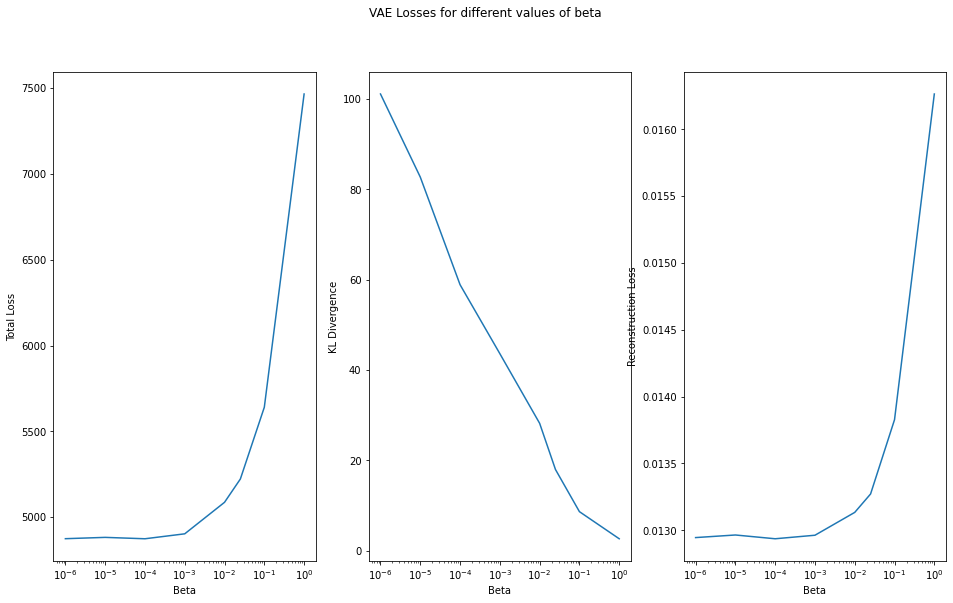

In [104]:
# Extract train and valid reconstruction losses:
losses = [test_losses_VAE,kl_losses, rec_losses]
labels = ['Total Loss','KL Divergence', 'Reconstruction Loss']
title  = 'VAE Losses for different values of beta' 
# Initialize figure:
fig, axs  = plt.subplots(1,len(labels))
  
for index, loss in enumerate(losses):
  # Plot reconstruction losses:
  axs[index].plot(betas, loss)
  axs[index].set_xlabel('Beta')
  axs[index].set_ylabel(labels[index])
  axs[index].set_xscale('log')

fig.suptitle(title)
plt.show()
plt.close()

From the plots it can be obsereved that the KL-divergence almost decrease linarly on logscale with increasing values for beta. However, the construction loss increases almost exponentialy.

For the IHDA algorithm it is required to derive a VAE that comes with good reconstruction performance while at the same time having having a bounded latent space. Basically we are looking for a VAE with maximal restriction on the latent space while simultanously delivering good reconstruction performance. To choose this VAE a second plot will considered. 

In following the accuracy of the baseline classifier on reconstructed dataset is plotted:

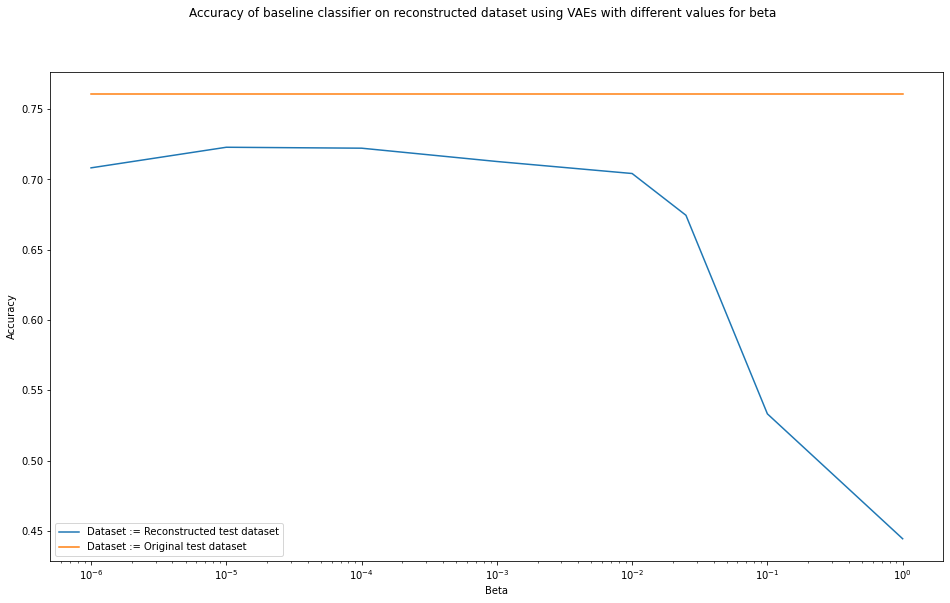

In [114]:
title = 'Accuracy of baseline classifier on reconstructed dataset using VAEs with different values for beta'
idx = int(np.where(np.array(betas) == 0.025)[0])
fig, axs  = plt.subplots(1,1)
axs.plot(betas,   acc_clas, label = 'Dataset := Reconstructed test dataset' )
axs.plot(betas,   test_acc_ref*np.ones(np.shape(betas)),label = 'Dataset := Original test dataset')
axs.set_xlabel('Beta')
axs.set_ylabel('Accuracy')
axs.set_xscale('log')
axs.legend()
fig.suptitle(title)
plt.show()
plt.close()

It can be recognized that the accuracy of the baseline classifier on the reconstructed dataset stays almost constant up to an value of beta 0.01. For higher beta values the accuracy starts to drop massivley.

#**Evaluate reconstruction performance of one VAE for one selected value of beta:**

In this section the VAE belonging to only one value of beta can be evaluted. This should help to use the optimal value for beta. Therefore specify the value for beta for which the VAE should be analyzed:

In [ ]:
beta = 0.025

Load the specified VAE:

In [ ]:
# directory of trained model
dir_VAE_1 = dir_IHDA + 'VAE/VAE_'+str(layer)+'/Models/VAE_beta_'+str(beta) + '_latent_dims_' + str(latent_dims) + '_epochs_' + str(epochs) +'/' + 'best_model.pth'
  
# Load and initialize trained VAE:
VAE_1  = VAE.VariationalAutoencoder(latent_dims,dropout_ratio_1).to(device)
VAE_1  = basic_functions.initialize_model(VAE_1,dir_VAE_1)
VAE_1.eval()



VariationalAutoencoder(
  (encoder): Encoder(
    (batch1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batch3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=753, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=500, bias=True)
    (fc3): Linear(in_features=500, out_features=500, bias=True)
    (fc4): Linear(in_features=500, out_features=8, bias=True)
    (fc5): Linear(in_features=500, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=8, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=500, bias=True)
    (fc3): Linear(in_features=500, out_features=500, bias=True)
    (fc4): Linear(in_features=500, out_features=753, bias=True)
    (dropout): Dropout(p=0.25, inplace=False)
  )
)

**Plot orginal versus reconstructed signal of one test sample:**
A good reconstruction performs is desired, since the IHDA utilizes reconstructions of the original singal to retrain the classifier.

To evaluate the reconstruction performance, first single samples of the test set (not used during training) are fed through the VAE, which results in their reconstructions.

The orignal versus the reconstructed signal is plotted. This allows to get feeling of what the VAE is doing. However, conclusions about the overall reconstruction performance on large datasets of the VAE can not be drawn.

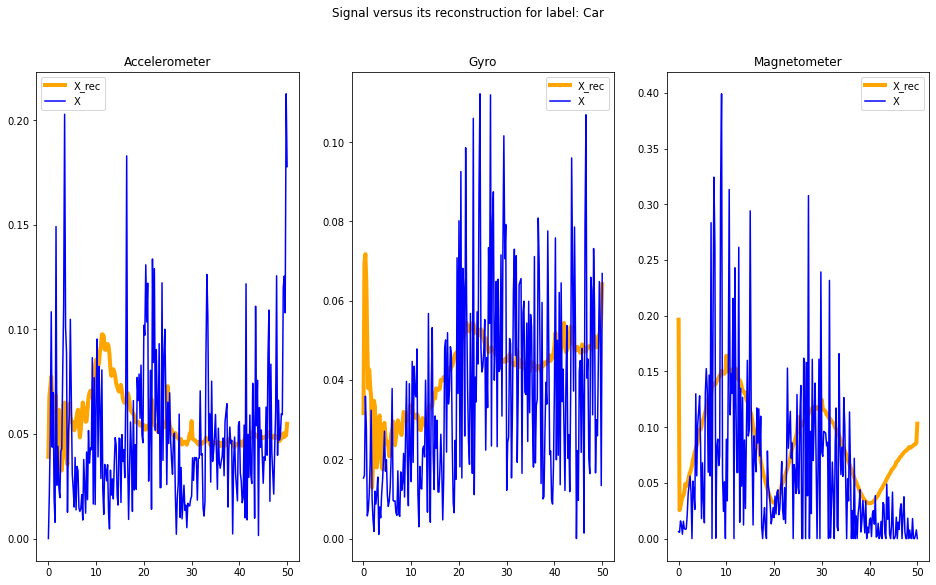

In [ ]:
idx_sample = np.random.randint(0,len(x_test),1)
x_sample   = x_test[idx_sample].view(753)
y_sample   = y_test[idx_sample].detach().cpu().numpy()
x_rec      = VAE_1(x_sample.to(device)).detach().cpu().numpy()
x_rec      = np.reshape(x_rec,753)
x_sample   = x_sample.detach().cpu().numpy()

eval_VAE.plot_x_rec_vs_x(x_rec,x_sample,y_sample)

**Evaluate classification performance of reconstructed signals on baseline classifier**

To get an indication about the reconstruction performance of the VAE on large dataset, the original testdataset dataset *x_test* will be fed through the VAE to generate their reconstrcutions. 

Afterwards the performance of the reconstructed and original dataset on the baseline classifier is calculated and compared. It is assumed that the smaller the performance difference between reconstructed and original dataset the better the reconstructed signal resembels the original dataset.

Generate reconstructed dataset of *x_test*:

In [ ]:
x_test_rec      = VAE_1(x_test.to(device)).detach().cpu()
test_rec_loader = lpd.generate_dataloader(x_test_rec,y_test, batch_size, shuffle = True)

In [ ]:
del x_test_rec
torch.cuda.empty_cache()

Initialize baseline classifier:

In [ ]:
dropout_fc = 0
fc_base    = FC.FC(dropout_fc)
fc_base    = basic_functions.initialize_model(fc_base,dir_fc_base_best)

Print performance statistics on testset:

In [ ]:
criterion  = nn.CrossEntropyLoss()
test_loss_ref, test_acc_ref, test_f1_ref = eval_FC.test_classifier(testloader, fc_base, device,criterion)
print('------------------------------- Baseline classifier performance on original dataset: --------------------------------')
print("test_loss: {:.4f}, test_acc: {:.4f}, test_f1:{:.4f}".format(test_loss_ref, test_acc_ref,test_f1_ref))

------------------------------- Baseline classifier performance on original dataset: --------------------------------
test_loss: 1.5114, test_acc: 0.7608, test_f1:0.7606


Print performance statistics on reconstructed trainset:

In [ ]:
criterion  = nn.CrossEntropyLoss()
test_loss, test_acc, test_f1 = eval_FC.test_classifier(test_rec_loader, fc_base, device,criterion)
print('-------------------------------Baseline classifier performance on reconstructed signal: --------------------------------')
print("test_loss: {:.4f}, test_acc: {:.4f}, test_f1:{:.4f}".format(test_loss, test_acc,test_f1))

-------------------------------Baseline classifier performance on reconstructed signal: --------------------------------
test_loss: 1.5945, test_acc: 0.6767, test_f1:0.6515


#**Evaluate latent space of one VAE for one selected value of beta:**

After evaluating the reconstruction performance of the VAE, the latent space needs to be evaluated.

A bounded and structed latent space is desired. It should be structured, since the IHDA algorithm utilizes its structure to find samples that are underrepresented. Furthermore, it should be bounded, since otherwise the notion of *close* in the latent space might become meaningless.

**Check for posterior collapse:**

First, it is checked whether the VAE is facing posterior collapse for some of its latent variables.

In the case of posterior collapse the VAE ended up in a minimum of the loss function for which the inputs are mapped to a standard normal distributions in the latent space. In this case the VAE has not learned to compress any information of the input in the latent space.

To check whether the VAE is facing posterior collapse *n* datasamples are mapped through the encoder of the VAE to its latent space. Every datasample is mapped to a gaussian distribution specified by a mean mu and varaiance var. If a certain percentage of the of the *n* variances is mapped close to a standard deviation of 1, the risk of facing posterior collapse is high. 

In [ ]:
n          = 50000
idx_sample = np.random.randint(0,len(x_test),n) 
x_sample   = x_test[idx_sample]
eval_VAE.calc_risk_pc(VAE_1, x_sample, latent_dims,device)

Potentially you are not facing posterior collapse for the following latent dimensions:
[0, 1, 2, 3, 4, 5, 6, 7]
The belonging risks for posterior collapse are: 
[0.0, 0.0, 4e-05, 2e-05, 0.0, 0.0, 0.0, 0.0]
------------------------------------------------------------------------------------------------
Potentially you are facing posterior collapse for the following latent dimensions:
[]
The belonging risks for posterior collapse are: 
[]


**Plot latent space:**

To get a visual impression about the latent space of the VAE, the previous used *n* samples are mapped to the latent space, and their latent space representation is plotted. This helps to check whether indeed posterior collapse is present. Specify the two latent variables used for plotting as *lat_var_1* and *lat_var_2*.

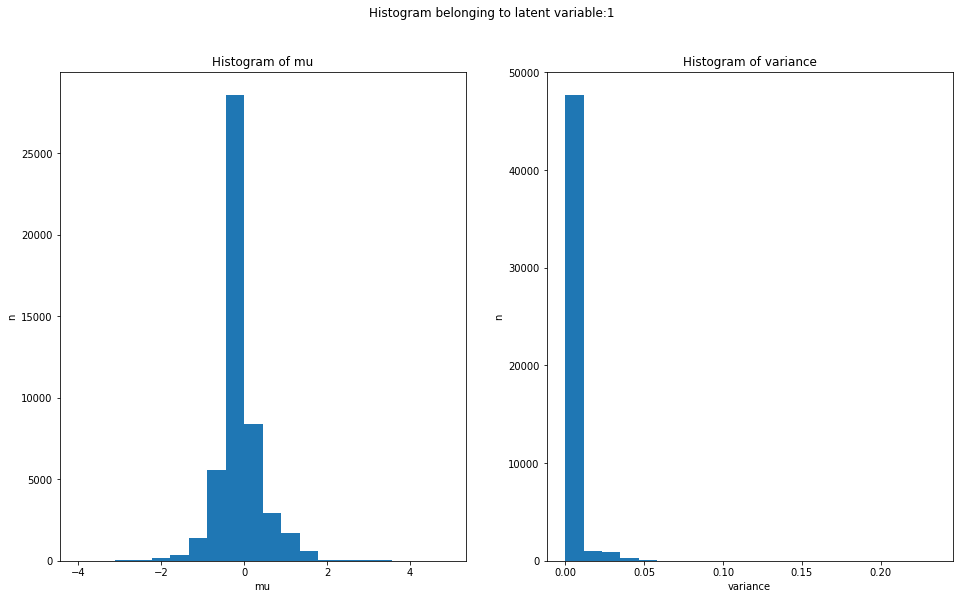

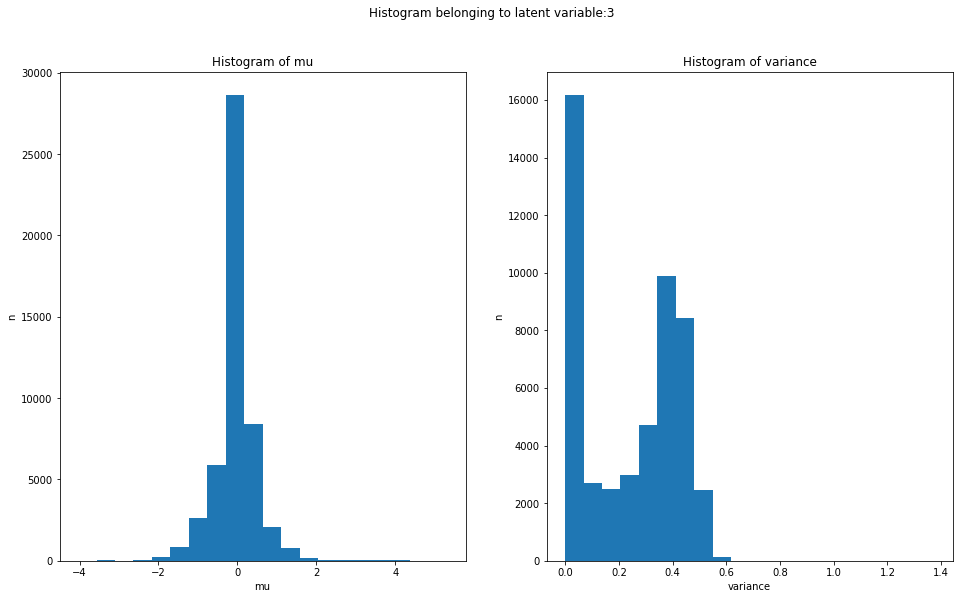

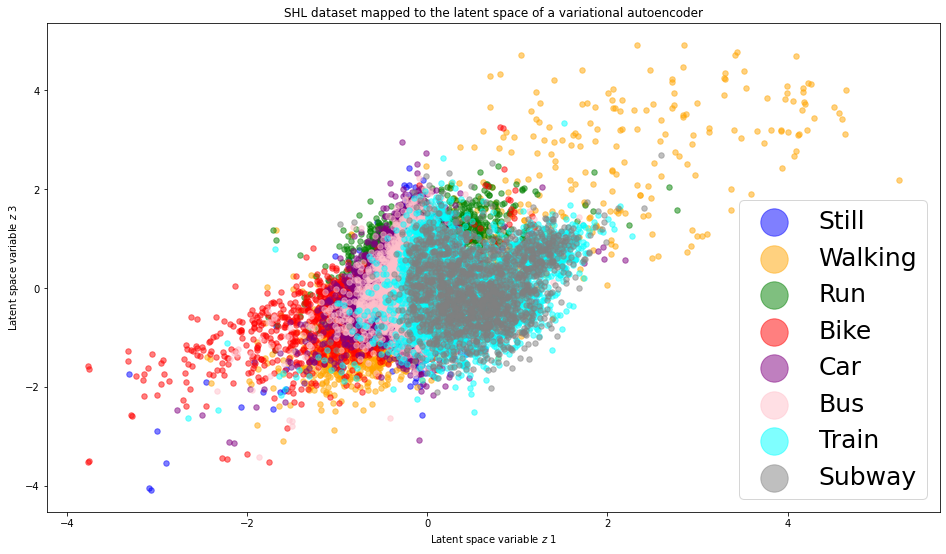

In [ ]:
# Define latent variable to plot:
lat_var_1 = 1
lat_var_2 = 3

# Calculate mean and variance: 
mu, var  = eval_VAE.calc_mu_var(device,VAE_1,x_sample)

eval_VAE.plot_hist(mu, var, lat_var_1)
eval_VAE.plot_hist(mu, var, lat_var_2)
eval_VAE.plot_latent(x_test,y_test,VAE_1,lat_var_1,lat_var_2,n_plot = 30000)